In [1]:
# Exercise sheet 4.2
# Jian Zhang, 219012058
# 19.10.31

In [117]:
import numpy as np
import sympy as sp
from sympy.parsing import sympy_parser as spp
import time
import matplotlib.pyplot as plt

In [149]:
# Globalized Newton's Method
# parameters:
# - obj, objective function
# - x0, the initial point
# - tol, tolerance, method should stop if the criterion 'gradient f(x_k) <= tol'
# - B1, B2, p, parameters for Newton condition
# - s, sigma, gamma, parameters for backtracking and Armijo condition
# - grad_method, default False, if True, use gradient as step
def newton_glob(obj, x0, tol, B1, B2, p, s, sigma, gamma, grad_method=False):
    
    start_time = time.time()
    print('Initial point', x0, 'Start iterating:')
    
    xn = [] # used to store iterates xk
    gn_norm = [] # used to store iterates of gradient xk
    iterations = 0
    
    x1, x2 = sp.symbols('x1 x2')
    symbols = obj.free_symbols
    # calculate gradient
    grad = sp.Matrix([sp.diff(obj, i) for i in symbols])
    # calculate Hessian
    hess = sp.Matrix([[sp.diff(g, i) for i in symbols] for g in grad])
    # inverse of Hessian
    if hess.det():
        hess_inv = hess.inv()
    else:
        print('det of objective function Hessian is not invertible')
    
    cur_point = x0
    
    cur_grad = grad.evalf(subs = {x1:x0[0],x2:x0[1]})
    norm = float(cur_grad.norm())
            
    cur_hess = hess.evalf(subs = {x1:x0[0],x2:x0[1]})
    
    while norm > tol:
        
        xn.append(cur_point)
        gn_norm.append(norm)
        
        # stop if Hessian is singular
        if cur_hess.det() == 0:
            print('Hessian is singular')
            break
        
        # Gradient method
        step = -cur_grad.T
        # Newton method
        if not grad_method:
            d = -cur_grad.T * cur_hess.inv()
            # calculate norm
            norm_d = float(d.norm())
            norm_d_p = norm_d ** p
            norm_d_sq = norm_d ** 2

            Min = min(B1,B2*norm_d_p)*norm_d_sq
            if np.dot(-cur_grad.T, d.T) >= Min:
                step = d
            else:
                step = -cur_grad.T
                    
        alpha = s
        pre_point = cur_point
        pre_value = obj.evalf(subs = {x1:pre_point[0], x2:pre_point[1]})
        cur_point = [pre_point[0] + alpha * step[0], pre_point[1] + alpha * step[1]]
        cur_value = obj.evalf(subs = {x1:cur_point[0], x2:cur_point[1]})
        
        while cur_value > pre_value + gamma*alpha*np.dot(cur_grad.T, step.T):
            alpha = alpha * sigma
            cur_point = [pre_point[0] + alpha * step[0], pre_point[1] + alpha * step[1]]
            cur_value = obj.evalf(subs = {x1:cur_point[0], x2:cur_point[1]})
        
        iterations += 1
        
        cur_grad = grad.evalf(subs = {x1:cur_point[0],x2:cur_point[1]})
        norm = float(cur_grad.norm())
        
        cur_hess = hess.evalf(subs = {x1:cur_point[0],x2:cur_point[1]})
        
        #print(iterations, cur_point)
        #if iterations % 500 == 0:
        #    print('iterations:', iterations, cur_point, 'Time Cost(s):', '%.3f'%(time.time() - start_time))
        
    print('Total', iterations, 'iterations. Time Cost(s):', '%.3f'%(time.time() - start_time), \
          'Converged point:', cur_point, '\n')
    
    return xn, gn_norm, cur_point
        

In [82]:
# Test objective function
f1 = spp.parse_expr('-13 + x1 + ((5 - x2) * x2 - 2) * x2')
f2 = spp.parse_expr('-29 + x1 + ((x2 + 1) * x2 - 14) * x2')
f = f1**2 + f2**2

In [83]:
# Verify that x1* is a globbal minimizer of f
def verifyGlobalMin(f):
    x1, x2 = sp.symbols('x1 x2')
    print('f(x1*) = ', f.evalf(subs = {x1:5,x2:4}))
    print('f(x2*) = ', f.evalf(subs = {x1:(53 + 4 * np.sqrt(22)) / 3, x2:(2 + np.sqrt(22)) / 3}))
    print('f(x3*) = ', f.evalf(subs = {x1:(53 - 4 * np.sqrt(22)) / 3, x2:(2 - np.sqrt(22)) / 3}))

verifyGlobalMin(f)

f(x1*) =  1.07486017721073e-136
f(x2*) =  819.010259352310
f(x3*) =  48.9842536792400


Initial point [-50, 7] Start iterating:
Total 8 iterations. Time Cost(s): 0.377 Converged point: [4.99999999997935, 4.00000000000154] 



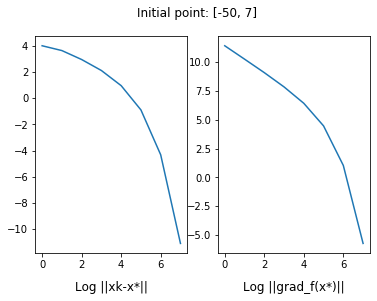

Initial point [20, 7] Start iterating:
Total 8 iterations. Time Cost(s): 0.381 Converged point: [4.99999999996832, 4.00000000000236] 



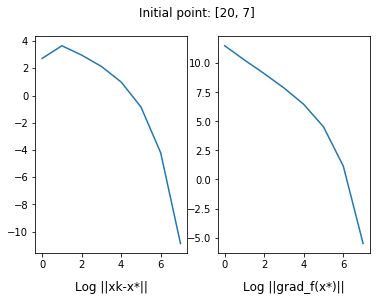

Initial point [20, -18] Start iterating:
Total 16 iterations. Time Cost(s): 0.672 Converged point: [11.4127789869019, -0.896805253274496] 



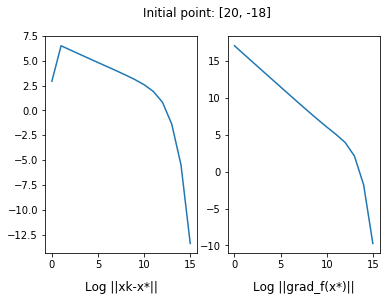

Initial point [-8, -50] Start iterating:
Total 21 iterations. Time Cost(s): 0.735 Converged point: [11.4127789869021, -0.896805253274476] 



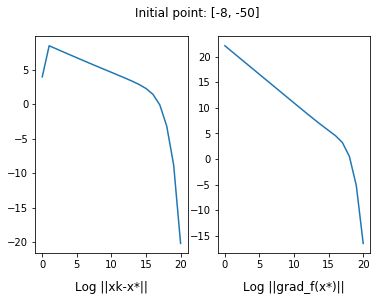

In [173]:
# Test initial points
intial_points = [ [-50, 7], [20, 7], [20, -18], [-8, -50] ]
# Apply Globalized Newton Method
for point in intial_points:
    
    xn, gn_norm, converged_point = newton_glob(f, point, 1e-8, 1e-6, 1e-6, 0.1, 1, 0.5, 0.1)
    
    # calculate for plot
    xk_minus_xstar_norm = []
    for xk in xn:
        k1 = float(xk[0] - converged_point[0])
        k2 = float(xk[1] - converged_point[1])
        norm = np.sqrt(k1 ** 2 + k2 ** 2)
        xk_minus_xstar_norm.append(norm)
    
    plt.figure()
    plt.subplot(121)
    plt.plot(np.log(xk_minus_xstar_norm))
    plt.title('Log ||xk-x*||', y=-0.2)
    plt.subplot(122)
    plt.plot(np.log(gn_norm))
    plt.title('Log ||grad_f(x*)||', y=-0.2)
    
    plt.suptitle('Initial point: {}'.format(point))
    plt.show()

In [100]:
# Apply Gradient Method
for point in intial_points[0:]:
    
    xn, gn_norm, converged_point = newton_glob(f, point, 1e-5, 1e-6, 1e-6, 0.1, 1, 0.5, 0.1, grad_method=True)

Initial point [-50, 7] Start iterating:
Total 6596 iterations. Time Cost(s): 354.818 Coverage points: [11.4127696797573, -0.896805799403163] 

Initial point [20, 7] Start iterating:
Total 8858 iterations. Time Cost(s): 618.710 Coverage points: [5.00000247891144, 3.99999995558952] 

Initial point [20, -18] Start iterating:
Total 8767 iterations. Time Cost(s): 604.106 Coverage points: [5.00000256776246, 3.99999995413150] 

Initial point [-8, -50] Start iterating:
Total 8758 iterations. Time Cost(s): 619.690 Coverage points: [4.99999749903115, 4.00000004479747] 



In [13]:
# The Conjugate Gradient Method
# parameters
# - A, symmetric and positive definite matrix
# - b, vector b
# - x0, initial point
def cg_method(A,b,x0,tol,max_iter):
    
    d0 = b - np.dot(A,x0)
    r0 = d0
    x1 = x0
    k  = 1
    
    while(k < max_iter):
        a0 = np.dot(r0,r0) / np.dot(np.dot(d0,A),d0)
        x1 = x0 + np.dot(a0,d0)
        r1 = r0 - np.dot(np.dot(a0,A),d0)
        
        if(np.linalg.norm(r1) <= tol):
            break
        b0 = np.dot(r1,r1) / np.dot(r0,r0)
        d1 = r1 + np.dot(b0,d0)
        x0, d0, r0 = x1, d1, r1
        k += 1
        
    return x1,k

In [458]:
A = np.array([[1.,-1.,0.],\
              [-1.,2.,1.],\
              [0.,1.,5.]])
b = np.array([3.,-3.,4.])
guess = np.array([0.,0.,0.])
x,n = cg_method(A,b,guess,100,0.00000001)

In [461]:
# generate test case
def generatePara(n):
    A = np.ones((n, n))
    row, col = np.diag_indices(n)
    A[row,col] = np.array([i for i in range(1, n + 1)])
    
    b = np.ones((n,1))
    x0 = np.zeros((n,1))
    
    return A, b, x0

[ 2. -1.  1.]


In [462]:
np.linalg.solve(A,b)

array([ 2., -1.,  1.])